## 配置參數

In [1]:
import torch
from torch import nn

In [2]:
class CFG:
  SEED = 24

device = "cuda" if torch.cuda.is_available() else "cpu"

## 獲取數據

＄ 將要使用的數據是 Food101 數據集的一個子集。Food101 是一個流行的計算機視覺基準測試，因為它包含 101 種不同食物的 1000 張圖像，總計 101,000 張圖像（75,750 張訓練和 25,250 張測試）。

＄ 我們將從 3 種食物類別開始，而不是 101 種：比薩餅、牛排和壽司。我們將從每類隨機選取的 10% 圖像開始（從小處開始，必要時再進行擴展）。

[原始 Food101 數據集和紙質網站](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)

In [3]:
import requests
import zipfile
from pathlib import Path

# 设置数据文件夹路径
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# 如果图像文件夹不存在，则下载并准备数据...
if image_path.is_dir():
    print(f"{image_path} 目录已存在。")
else:
    print(f"未找到 {image_path} 目录，正在创建...")
    image_path.mkdir(parents=True, exist_ok=True)

    # 下载比萨饼、牛排、寿司数据
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("正在下载比萨饼、牛排、寿司数据...")
        f.write(request.content)

    # 解压比萨饼、牛排、寿司数据
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("正在解压比萨饼、牛排、寿司数据...")
        zip_ref.extractall(image_path)


未找到 data/pizza_steak_sushi 目录，正在创建...
正在下载比萨饼、牛排、寿司数据...
正在解压比萨饼、牛排、寿司数据...


＄ 我們可以通過編寫一個小的幫助程式函數來檢查數據目錄中的內容，以遍歷每個子目錄並計算存在的檔。

In [6]:
import os

def walk_through_dir(dir_path):
  """
  遍历目录并返回其内容。

  Args:
    dir_path (str or pathlib.Path): 目标目录

  Returns:
    打印出：
      dir_path 中子目录的数量
      每个子目录中图像（文件）的数量
      每个子目录的名称
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"目录 '{dirpath}' 中有 {len(dirnames)} 个子目录和 {len(filenames)} 张图片。")

walk_through_dir(image_path)


目录 'data/pizza_steak_sushi' 中有 2 个子目录和 0 张图片。
目录 'data/pizza_steak_sushi/test' 中有 3 个子目录和 0 张图片。
目录 'data/pizza_steak_sushi/test/sushi' 中有 0 个子目录和 31 张图片。
目录 'data/pizza_steak_sushi/test/steak' 中有 0 个子目录和 19 张图片。
目录 'data/pizza_steak_sushi/test/pizza' 中有 0 个子目录和 25 张图片。
目录 'data/pizza_steak_sushi/train' 中有 3 个子目录和 0 张图片。
目录 'data/pizza_steak_sushi/train/sushi' 中有 0 个子目录和 72 张图片。
目录 'data/pizza_steak_sushi/train/steak' 中有 0 个子目录和 75 张图片。
目录 'data/pizza_steak_sushi/train/pizza' 中有 0 个子目录和 78 张图片。


### ＠ 設置我們的訓練和測試路徑。

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### ＠ 視覺化圖像

隨機圖像路徑：data/pizza_steak_sushi/train/steak/2979061.jpg
圖像類別：steak, 圖像高度：512, 圖像寬度：512


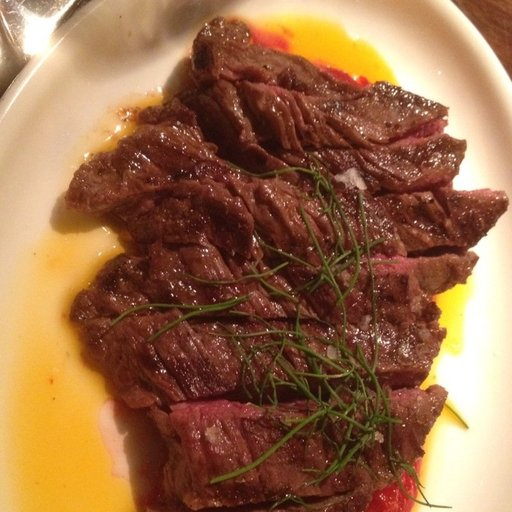

In [13]:
# 隨機抓一個圖像起來做可視化

import random
from PIL import Image
random.seed(CFG.SEED) # <- 嘗試更改這個並觀察發生了什麼

# 獲取所有圖像路徑（* 表示“任意組合”）
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 獲取隨機圖像路徑
random_image_path = random.choice(image_path_list)

# 從路徑名稱中獲取圖像類別（圖像類別是存儲圖像的目錄的名稱）
image_class = random_image_path.parent.stem
# file_extension = random_image_path.suffix 如果要得到副檔名

img = Image.open(random_image_path)

# 5. 打印元數據
print(f"隨機圖像路徑：{random_image_path}")
print(f"圖像類別：{image_class}, 圖像高度：{img.height}, 圖像寬度：{img.width}")
img

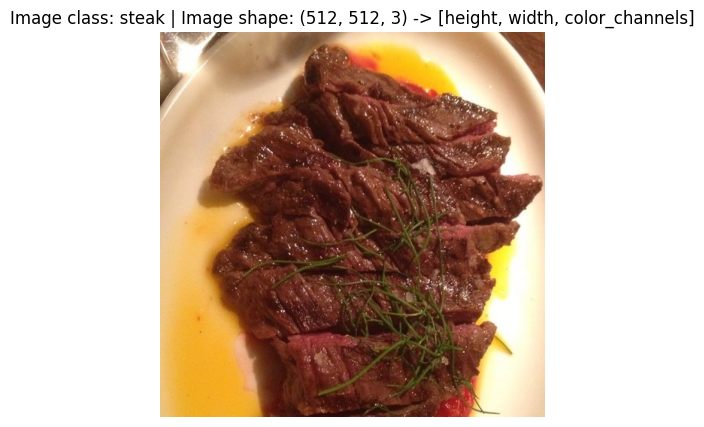

In [16]:
# 而同樣圖片也可以在matplotlib.pyplot.imshow() 裡面做。只是我們必須先將圖像轉換為 NumPy 陣列。
import numpy as np
import matplotlib.pyplot as plt

# image -> array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(6, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 轉換數據

＄ 在將圖像數據與 PyTorch 一起使用之前，我們需要：
- 把它變成張量（我們圖像的數值表示）。
- 把它變成 `torch.utils.data.Dataset`，然後再裝進`torch.utils.data.DataLoader`` ，我們簡稱為 和 Dataset DataLoader 。


＄ PyTorch 有幾種不同類型的預構建數據集和數據集載入器，具體取決於您正在處理的問題。
- Vision 視覺	torchvision.datasets
- Audio 音訊	torchaudio.datasets
- Text 發簡訊	torchtext.datasets
- Recommendation system 推薦系統	torchrec.datasets

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### @ 使用 torchvision.transforms

＄ 我們要透過`torchvision.transforms `將圖片轉換成張量。

＄ `torchvision.transforms `包含許多用於格式化圖像、將它們轉換為張量甚至操縱它們以進行數據增強（更改數據以使模型更難學習的做法，我們稍後會看到）目的的預構建方法。

＄ 我們可以使用`torchvision.transforms.Compose()`編譯圖片轉成張量度這些步驟。


In [ ]:
# image to tensor
data_transform = transforms.Compose([
    # 將圖像調整大小為 64x64
    transforms.Resize(size=(64, 64)),
    # 在水平方向上隨機翻轉圖像
    transforms.RandomHorizontalFlip(p=0.5), # p = 翻轉機率, 0.5 = 50% 的機率
    # 將圖像轉換為 torch.Tensor
    transforms.ToTensor() # 這也將所有像素值從 0 到 255 轉換為 0.0 到 1.0 之間
])

In [31]:
# 定義一個可視化的函數，他將原本片及經過處理吼的圖片做比較
def plot_transformed_images(image_paths, transform, n=3, seed=CFG.SEED):
    """繪製從 image_paths 中隨機選擇的一系列圖像。

    將從 image_paths 中選擇的 n 張圖像打開，對其應用 transform，並將它們並排繪製。

    Args:
        image_paths (list): 目標圖像路徑列表。
        transform (PyTorch 轉換): 要應用於圖像的轉換。
        n (int, optional): 要繪製的圖像數量。默認為 3。
        seed (int, optional): 隨機生成器的隨機種子。默認為 42。
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
          # 畫出原本照片
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"original \nsizes: {f.size}")
            ax[0].axis("off")
          # 轉換成tensor
            # 注意：permute() 會改變圖像的形狀以適應 matplotlib
            # （PyTorch 的默認形狀為 [C, H, W]，但 Matplotlib 的形狀為 [H, W, C]）
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

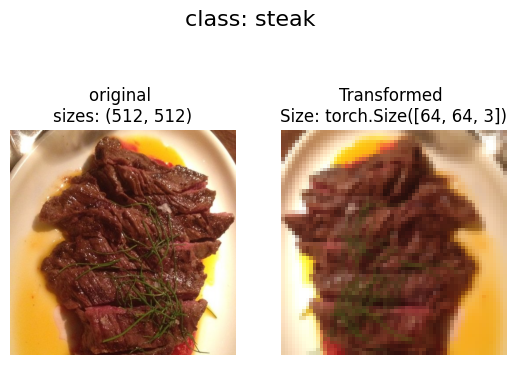

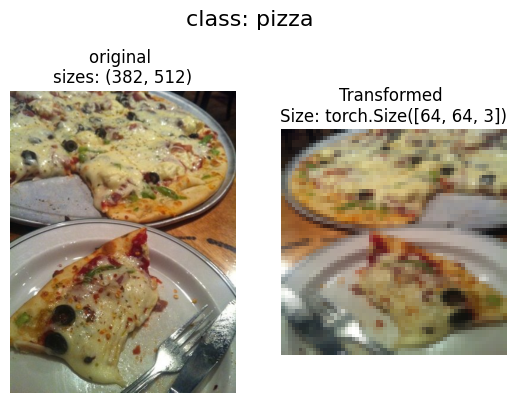

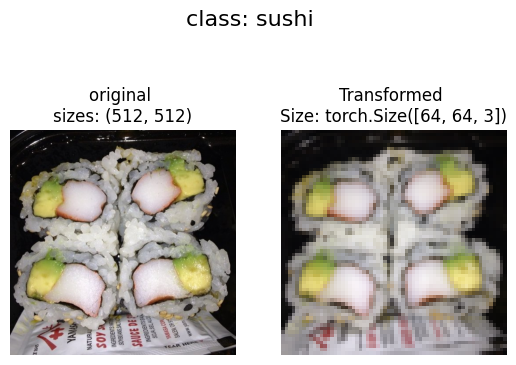

In [32]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)

### @ 選項 1：使用 ImageFolder

＄ 將我們的圖像數據轉換為 Dataset 能夠與 PyTorch 一起使用的資料了。

＄ 由於我們的數據是標準圖像分類格式，因此我們可以使用類 torchvision.datasets.ImageFolder 。

In [23]:
# 使用 ImageFolder 創建數據集
from torchvision import datasets

# 創建訓練數據集
train_data = datasets.ImageFolder(root=train_dir,  # 圖像的目標文件夾
                                  transform=data_transform,  # 要對數據（圖像）執行的轉換
                                  target_transform=None)  # 對標籤（如果需要）執行的轉換

# 創建測試數據集
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

# 打印訓練和測試數據集的信息
print(f"訓練數據集:\n{train_data}\n測試數據集:\n{test_data}")


訓練數據集:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
測試數據集:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [24]:
# 讓我們通過檢查 classes 和 class_to_idx 屬性以及訓練集和測試集的長度來檢查它們。
class_names = train_data.classes
print(class_names)

class_dict = train_data.class_to_idx
print(class_dict)

print(len(train_data), len(test_data))

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
225 75


In [26]:
# 查看圖像和標籤
img, label = train_data[0]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


### @ 將載入的圖像轉換為 DataLoader

＄ num_workers：定義將創建多少個子進程來載入資料，設置的值 num_workers 越高，PyTorch 用於載入數據的計算能力就越大。

＄ 通常通過 Python 將其設置為機器上的 CPU 總數 os.cpu_count() 。這確保了 DataLoader 招募盡可能多的內核來載入數據。

In [30]:
# 將訓練和測試數據集轉換為 DataLoader
from torch.utils.data import DataLoader

# 創建訓練 DataLoader
# 為了簡單起見，我們將使用 a batch_size=1 和 num_workers=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,  # 每個批次有多少樣本？
                              num_workers=1,  # 用於數據加載的子進程數？（數字越高，進程越多）
                              shuffle=True)  # 是否對數據進行洗牌？

# 創建測試 DataLoader
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)  # 通常不需要對測試數據進行洗牌

# 打印訓練和測試 DataLoader
print(train_dataloader, test_dataloader)
print()


# 讓我們嘗試一下並檢查形狀。
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

<torch.utils.data.dataloader.DataLoader object at 0x7b90f0deab60> <torch.utils.data.dataloader.DataLoader object at 0x7b90f0d05120>

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


### @ 選項 2：使用自訂 Dataset 載入圖像資料

＄ 教學連結：https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation

## 其他形式的轉換-資料增強（data augmentation）

＄ 數據增強是以人為增加訓練集多樣性的方式更改數據的過程。

＄ 在這個人工改變的數據集上訓練一個模型，希望能產生一個能夠更好地泛化的模型（它學習的模式對未來看不見的例子更健壯）。

＄ 您可以在 PyTorch 的轉換圖示例中看到許多不同的 torchvision.transforms 數據增強範例。
[Illustration of Transforms example.](https://pytorch.org/vision/stable/auto_examples/)

＄ 機器學習就是要利用隨機性的力量，研究表明，隨機變換（如 transforms.RandAugment() 和 transforms.TrivialAugmentWide() ）通常比手動選擇的變換表現更好。

＄ transforms.TrivialAugmentWide() 要注意的主要參數是 num_magnitude_bins=31 。它定義了在應用特定變換時將選擇強度值的範圍大小， 0 即無範圍和 31 最大範圍（最高強度的最高幾率）。

In [35]:
from torchvision import transforms

# 訓練數據的轉換
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整大小為 (224, 224)
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # 做一些微小的增強（如模糊、旋轉等），num_magnitude_bins表示強度
    transforms.ToTensor()  # 將圖像轉換為張量，並將像素值調整到 0 到 1 之間
])

# 測試數據的轉換
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # 調整大小為 (224, 224)
    transforms.ToTensor()  # 將圖像轉換為張量，並將像素值調整到 0 到 1 之間
])


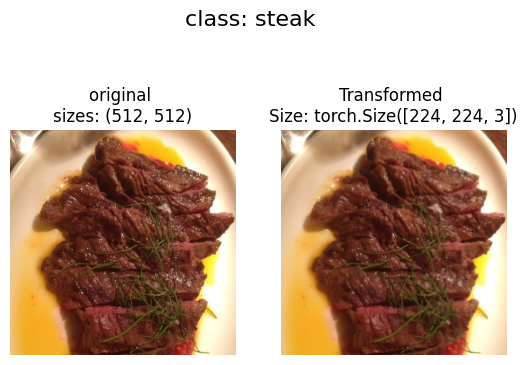

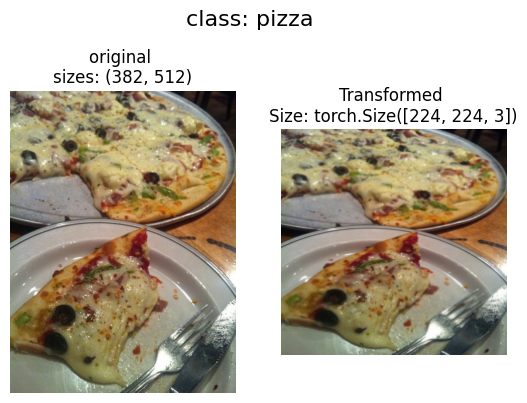

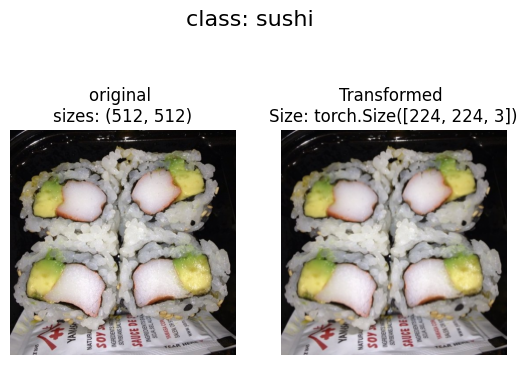

In [37]:
# 一開始的
# plot_transformed_images(image_path_list, transform=data_transform, n=3)

# 有做資料增強的
plot_transformed_images(image_path_list, transform=train_transforms, n=3)

# Model_0: 沒有數據增強的 TinyVGG

## 為模型 0 建立轉換和載入數據

In [39]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [40]:
# load data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

In [41]:
# image -> DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")


train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

Creating DataLoader's with batch size 32 and 2 workers.


## 創建TinyVGG模型類

In [54]:
# 宣告模型
class TinyVGG(nn.Module):
    """
    從以下連結中複製的 TinyVGG 模型結構:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        # 第一個卷積塊
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # 視窗大小
                      stride=1, # 預設值
                      padding=1), # padding方式，選項有"valid"（不填充）、"same"（輸出與輸入具有相同形狀）或指定整數值
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # 預設步幅值與核心尺寸相同
        )
        # 第二個卷積塊
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 分類器
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 下方會說明16*16推倒方式
            nn.Linear(in_features=hidden_units*16*16, # 16*16 是從圖像形狀中推導出來的
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- 利用運算符融合的好處

In [55]:
# 初始化模型
torch.manual_seed(CFG.SEED)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

## 嘗試對單個圖像進行前向傳遞（以測試模型）

In [56]:
# 1. 從 DataLoader 中獲取一個圖像和標籤的批次
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. 從批次中取出一個單獨的圖像並對其進行 unsqueeze 處理，以使其形狀符合模型
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. 對單個圖像執行前向傳播
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. 輸出發生的情況並將模型的 logits -> 預測概率 -> 預測標籤
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")


Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0059, 0.0031, 0.0496]])

Output prediction probabilities:
tensor([[0.3288, 0.3278, 0.3434]])

Output prediction label:
tensor([2])

Actual label:
0


## 用於 torchinfo 瞭解通過模型的形狀

＄ torchinfo 附帶一個 summary() 方法，該方法接受 PyTorch 模型以及一個 input_shape ，並返回張量在模型中移動時發生的情況。

In [57]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 建立訓練和測試迴圈函數

＄ 這邊針對函數要做一些優化：

＄ 訓練函數：train_step() - 接受一個模型、一個 DataLoader 損失函數和一個優化器，並在 DataLoader 上訓練模型。

＄ 測試函數：test_step() - 採用模型、a DataLoader 和loss函數，並在 DataLoader 上計算模型。

＄ train()：執行 1.和 2.一起表示給定數量的 epoch，並返回一個結果字典。

In [58]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # 將模型設置為訓練模式
    model.train()

    # 設置訓練損失和訓練準確度值
    train_loss, train_acc = 0, 0

    # 遍歷數據加載器中的數據批次
    for batch, (X, y) in enumerate(dataloader):
        # 將數據發送到目標設備
        X, y = X.to(device), y.to(device)

        # 1. 前向傳播
        y_pred = model(X)

        # 2. 計算並累積損失
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. 優化器梯度歸零
        optimizer.zero_grad()

        # 4. 損失反向傳播
        loss.backward()

        # 5. 優化器更新參數
        optimizer.step()

        # 計算並累積準確度指標
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # 調整指標以獲得每批次的平均損失和準確度
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [59]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # 將模型設置為評估模式
    model.eval()

    # 設置測試損失和測試準確度值
    test_loss, test_acc = 0, 0

    # 打開推論上下文管理器
    with torch.inference_mode():
        # 遍歷數據加載器中的數據批次
        for batch, (X, y) in enumerate(dataloader):
            # 將數據發送到目標設備
            X, y = X.to(device), y.to(device)

            # 1. 前向傳播
            test_pred_logits = model(X)

            # 2. 計算並累積損失
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # 計算並累積準確度
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # 調整指標以獲得每批次的平均損失和準確度
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [60]:
# 建立一個 train() 函數來組合 train_step() 和 test_step()
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [61]:
# 訓練和評估模型 0
# 設置隨機種子
torch.manual_seed(CFG.SEED)
torch.cuda.manual_seed(CFG.SEED)

# 設置迭代次數
NUM_EPOCHS = 5

# 重新創建 TinyVGG 的一個實例
model_0 = TinyVGG(input_shape=3,  # 顏色通道數（RGB為3）
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# 設置損失函數和優化器
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# 開始計時
from timeit import default_timer as timer
start_time = timer()

# 訓練模型 model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# 結束計時並打印出執行時間
end_time = timer()
print(f"總訓練時間：{end_time-start_time:.3f} 秒")


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.1296 | train_acc: 0.2852 | test_loss: 1.1017 | test_acc: 0.2292
Epoch: 2 | train_loss: 1.0980 | train_acc: 0.3320 | test_loss: 1.1066 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0804 | train_acc: 0.3555 | test_loss: 1.0484 | test_acc: 0.4015
Epoch: 4 | train_loss: 1.0209 | train_acc: 0.4805 | test_loss: 1.1042 | test_acc: 0.2812
Epoch: 5 | train_loss: 0.9900 | train_acc: 0.4805 | test_loss: 1.1321 | test_acc: 0.3835
總訓練時間：9.226 秒


## 繪製模型0的損耗曲線

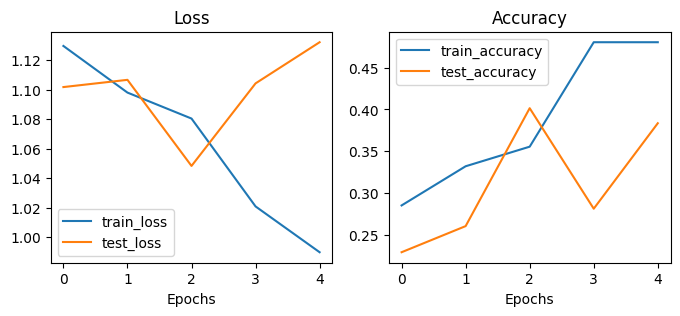

In [65]:
from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(8, 3))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_0_results)

## 理想的損失曲線應該是什麼樣子的？

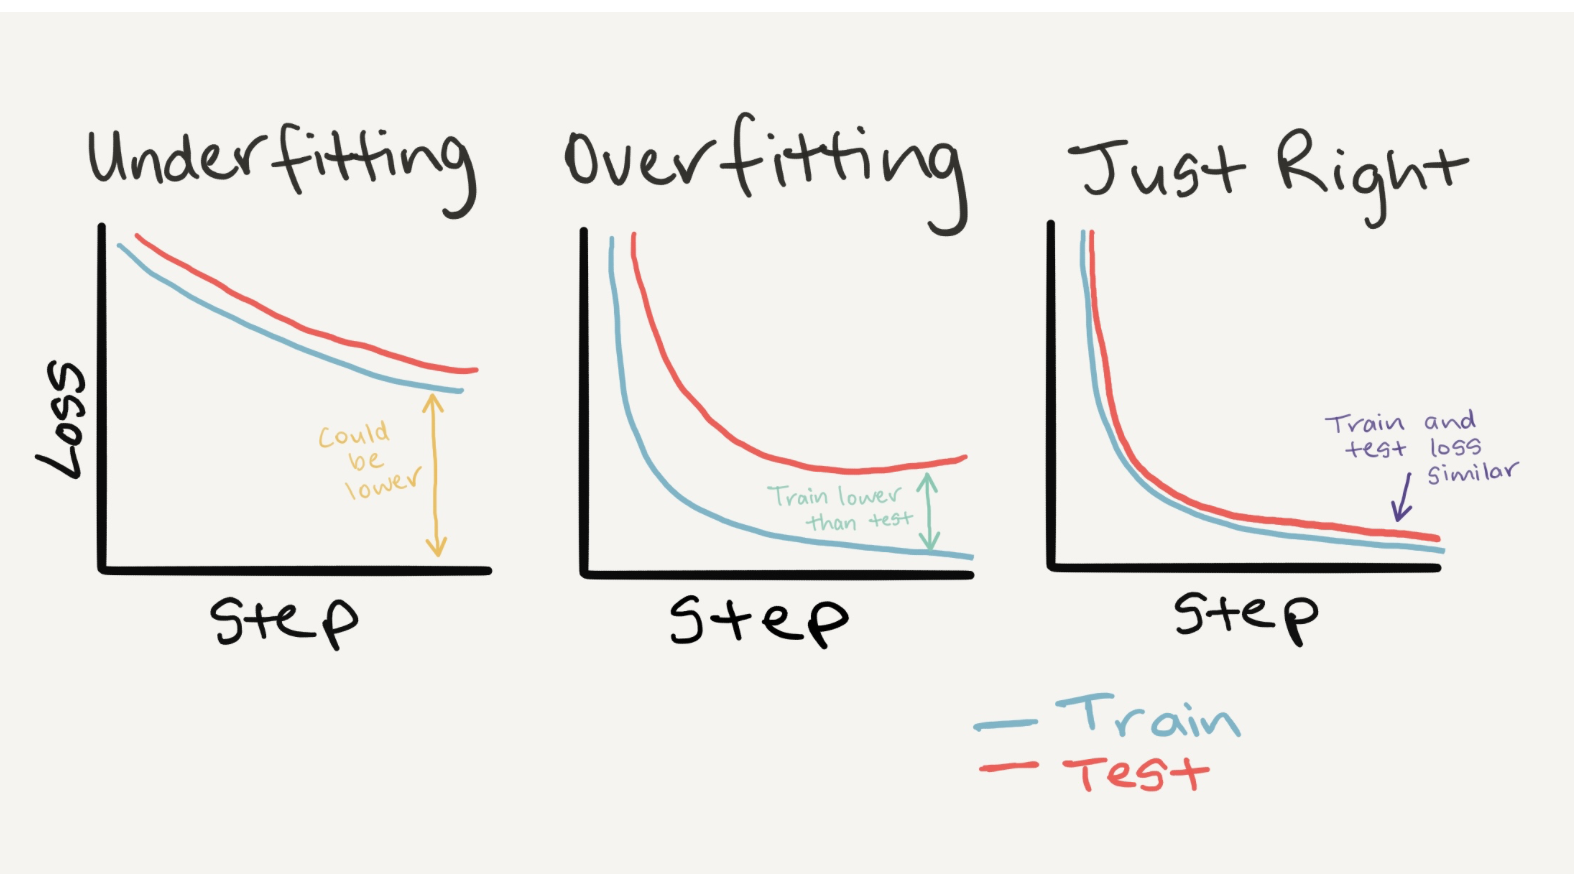

## ＠ 如何處理過擬合（overfitting）

-   獲取更多數據
-   簡化模型（Simplify）：模型可能過於複雜。這意味著它對數據模式的學習太好了，
-   使用數據增強（data augmentation）：數據增強以某種方式操作訓練數據，因此模型更難學習，因為它人為地為數據增加了更多種類。如果模型能夠學習增強數據中的模式，則該模型可能能夠更好地泛化到看不見的數據。
-   使用遷移學習（transfer learning）：[**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning)
-   使用輟學圖層（dropout layers）：輟學層隨機刪除神經網路中隱藏層之間的連接，有效地簡化了模型，但也使剩餘的連接變得更好。[`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
-   使用學習率衰減：模型訓練時慢慢降低學習率。
-   使用提前停止：在模型訓練開始過擬合之前，提前停止停止模型訓練。例如，假設模型的損失在過去 10 個週期內停止減少，那就將週期設定在 10 個週期之前。

### ＠ 如何處理欠擬合（overfitting）

-   向模型添加更多圖層/單位
-   調整學習率
-   訓練時間更長
-   使用遷移學習
-   使用較少的正則化

# Model 1: 具有數據增強功能的 TinyVGG

## 使用數據增強創建轉換

In [71]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 使用數據增強
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## 建立訓練和測試 Dataset DataLoader

In [72]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

# Turn Datasets into DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(CFG.SEED)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b90f0b7a830>,
 <torch.utils.data.dataloader.DataLoader at 0x7b90f0d05120>)

## 構建模型 1

In [73]:
# Create model_1 and send it to the target device
torch.manual_seed(CFG.SEED)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 訓練模型1

In [74]:
# Set random seeds
torch.manual_seed(CFG.SEED)
torch.cuda.manual_seed(CFG.SEED)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.1135 | train_acc: 0.2773 | test_loss: 1.1061 | test_acc: 0.2812
Epoch: 2 | train_loss: 1.0956 | train_acc: 0.2695 | test_loss: 1.0631 | test_acc: 0.4706
Epoch: 3 | train_loss: 1.0673 | train_acc: 0.4492 | test_loss: 1.1015 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1175 | train_acc: 0.3164 | test_loss: 1.1170 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0846 | train_acc: 0.3438 | test_loss: 1.1185 | test_acc: 0.3011
Total training time: 10.103 seconds


## 繪製模型 1 的損耗曲線

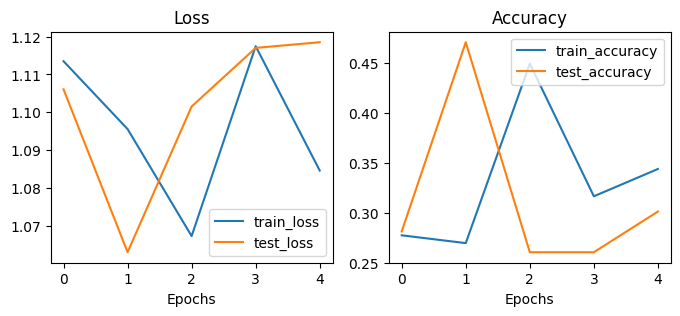

In [75]:
plot_loss_curves(model_1_results)

# 對圖片進行判斷

In [76]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

## 使用 PyTorch 載入要判斷的照片
＄ PyTorch torchvision 有幾種輸入和輸出（簡稱“IO”或“io”）方法，用於讀取和寫入圖像 torchvision.io 和視頻。

＄ 由於我們想載入圖像，我們將使用 torchvision.io.read_image()，此方法將讀取 JPEG 或 PNG 影像並將其轉換為 3 維 RGB 或灰度 torch.Tensor ，其值為 [0, 255] 資料類型 uint8 在 範圍內 。

In [77]:
import torchvision


custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")
print(f"Custom image tensor:\n{custom_image_uint8}\n")


Custom image shape: torch.Size([3, 4032, 3024])

Custom image dtype: torch.uint8
Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtyp

＄ 我們的 custom_image 張量是資料類型 torch.uint8 ，其值介於 [0, 255] .

＄ 但是我們的模型採用資料類型的 torch.float32 影像張量，其值介於 [0, 1] .

＄ 因此，在將自定義圖像用於模型之前，我們需要將其轉換為與模型訓練數據相同的格式。

＄ 因此要將載入圖片的函數進行修正

In [79]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")
print(f"Custom image tensor:\n{custom_image}\n")

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dtype: torch.float32
Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0

## 使用經過訓練的 PyTorch 對圖片進行判斷

＄ 現在還有一個問題，目前影像大小為 [3, 4032, 3024]，但我們訓練的模型尺寸為[3, 64, 64]

＄ 一種方法是使用 torchvision.transforms.Resize() .

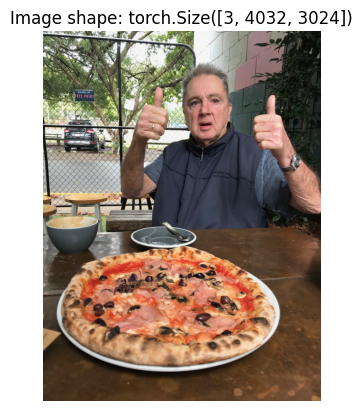

In [80]:
# 將原本的圖片輸出
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [81]:
# 創建轉換管道以調整圖像大小
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# 對目標圖像進行轉換
custom_image_transformed = custom_image_transform(custom_image)

# 打印出原始形狀和新形狀
print(f"原始形狀: {custom_image.shape}")
print(f"新形狀: {custom_image_transformed.shape}")


原始形狀: torch.Size([3, 4032, 3024])
新形狀: torch.Size([3, 64, 64])


接著開始判斷

In [83]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [85]:
# 會發現說，他多了*3，那這是因為color channels 為3的緣故，那就要把他進行壓縮
model_1.eval()
with torch.inference_mode():
    # 給他多一個維度1
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

# 讓我們將它們從logits -> 預測概率 ->預測標籤中轉換出來。
print(f"Prediction logits: {custom_image_pred}")
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")



# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])
Prediction logits: tensor([[-0.0142,  0.0423, -0.1580]])
Prediction probabilities: tensor([[0.3420, 0.3618, 0.2962]])
Prediction label: tensor([1])


'steak'

## 寫一個函數，把模型跟新圖片放進去，他幫你做預測及畫出來

In [86]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

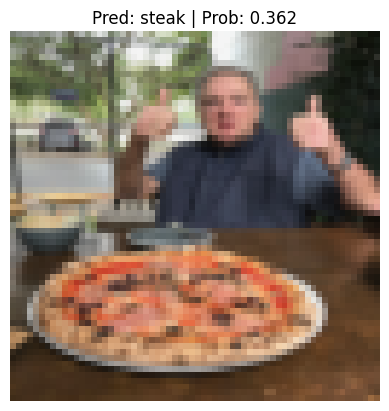

In [87]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)